In [1]:
import gensim

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from snorkel.labeling import labeling_function, PandasLFApplier, LFAnalysis, filter_unlabeled_dataframe
from snorkel.labeling.model import MajorityLabelVoter, LabelModel
from snorkel.utils import probs_to_preds

from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, precision_recall_curve

/home/david/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
VECTOR_SIZE = 300
WINDOW_SIZE = 10
MIN_COUNT = 2
WORKERS = 12

In [3]:
LABELS = {
    'None': 0,
    'Gain privileges': 1,
    'Sql Injection': 2,
    'Obtain Information': 3,
    'Memory corruption': 4,
    'CSRF': 5,
    'Execute Code': 6,
    'Denial Of Service': 7,
    'Cross Site Scripting': 8,
    'Http response splitting': 9,
    'Directory traversal': 10,
    'Bypass a restriction or similar': 11,
    'Overflow': 12
}
ABSTAIN = -1

In [97]:
cves = pd.read_csv('cves_labeled.csv').drop('Unnamed: 0', axis=1).reset_index(drop=True)

multiple_labels_idxs = [i for i in range(cves.shape[0]) if ',' in cves['labels'][i]]
cves = cves.drop(multiple_labels_idxs).reset_index(drop=True)

cves

,id,Published,Modified,summary,cvss,cwe,labels
0,CVE-2014-7552,2014-10-20T10:55:00.000Z,2014-11-14T14:13:00.000Z,The Zombie Diary (aka com.ezjoy.feelingtouch.z...,5.4,CWE-310,Obtain Information
1,CVE-2014-7745,2014-10-21T10:55:00.000Z,2014-11-14T14:17:00.000Z,The Flight Manager (aka com.flightmanager.view...,5.4,CWE-310,Obtain Information
2,CVE-2014-6661,2014-09-23T10:55:00.000Z,2014-09-26T15:55:00.000Z,The netease movie (aka com.netease.movie) appl...,5.4,CWE-310,Obtain Information
3,CVE-2014-5601,2014-09-09T01:55:00.000Z,2014-09-10T02:04:00.000Z,The 1800CONTACTS App (aka com.contacts1800.eco...,5.4,CWE-310,Obtain Information
4,CVE-2022-32550,2022-06-15T19:15:00.000Z,2022-06-24T17:27:00.000Z,An issue was discovered in AgileBits 1Password...,5.8,NVD-CWE-noinfo,None
...,...,...,...,...,...,...,...
9810,CVE-2016-6538,2018-07-06T21:29:00.000Z,2019-10-09T23:19:00.000Z,The TrackR Bravo mobile app stores the account...,3.3,CWE-200,None
9811,CVE-2016-6540,2018-07-06T21:29:00.000Z,2019-10-09T23:19:00.000Z,Unauthenticated access to the cloud-based serv...,3.3,CWE-200,Obtain Information
9812,CVE-2016-6541,2018-07-06T21:29:00.000Z,2019-10-09T23:19:00.000Z,TrackR Bravo device allows unauthenticated pai...,5.8,CWE-287,None
9813,CVE-2016-6539,2018-07-06T21:29:00.000Z,2019-10-09T23:19:00.000Z,The Trackr device ID is constructed of a manuf...,3.3,CWE-200,Obtain Information


In [98]:
summaries = cves['summary'].to_numpy()

def preprocess(data):
    for i in range(len(data)):
        yield gensim.utils.simple_preprocess(data[i])

documents = list(preprocess(summaries))

gensim_word2vec_lf_10 = gensim.models.Word2Vec(
    documents,
    vector_size=VECTOR_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS
)

gensim_word2vec_lf_10.train(documents, total_examples=len(documents), epochs=10)

gensim_word2vec_lf_50 = gensim.models.Word2Vec(
    documents,
    vector_size=VECTOR_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS
)

gensim_word2vec_lf_50.train(documents, total_examples=len(documents), epochs=50)

gensim_word2vec_lf_100 = gensim.models.Word2Vec(
    documents,
    vector_size=VECTOR_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS
)

gensim_word2vec_lf_100.train(documents, total_examples=len(documents), epochs=100)

(21169435, 34589700)

In [100]:
la = list(LABELS.keys())
hist = []

for l in la:
    hist.append(len([i for i in range(cves.shape[0]) if cves['labels'][i] == l]))

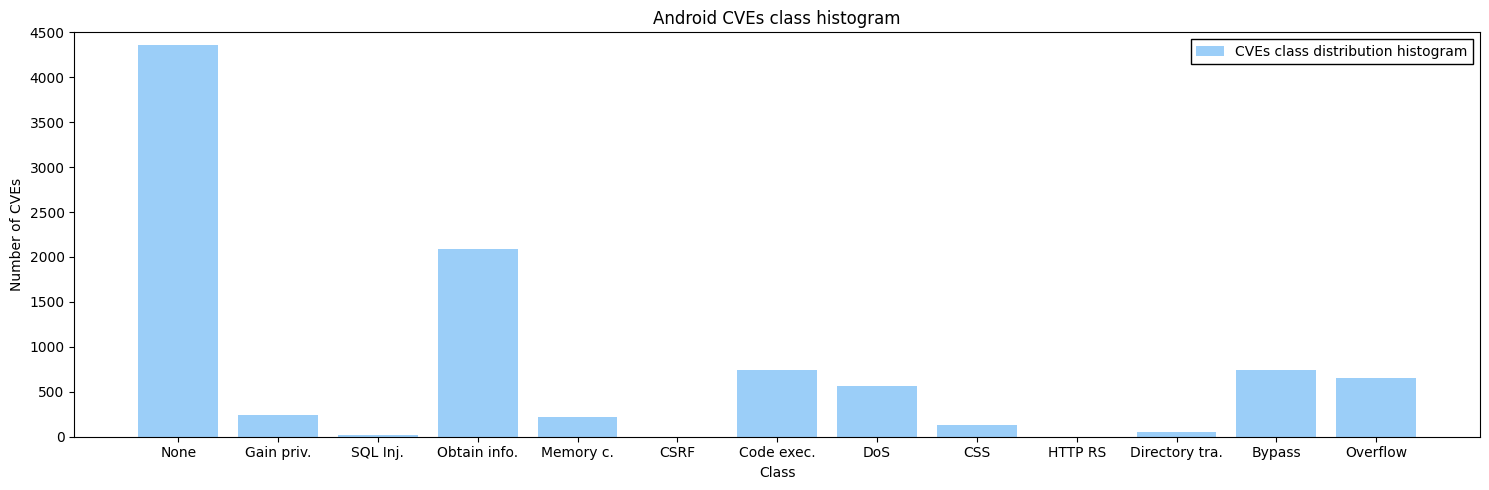

In [117]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.bar(
    ['None', 'Gain priv.', 'SQL Inj.', 'Obtain info.', 'Memory c.', 'CSRF', 'Code exec.', 'DoS', 'CSS', 'HTTP RS', 'Directory tra.', 'Bypass', 'Overflow'],
    hist,
    label='CVEs class distribution histogram',
    color='#9BCEF8',
    antialiased=True,
    linestyle='dotted'
)

plt.ylim((0, 4500))

plt.legend(
    ncols=1, loc='best', fancybox=False, framealpha=1,
    borderpad=0.4, edgecolor='black'
)

ax.set_xlabel('Class')
ax.set_ylabel('Number of CVEs')

plt.title('Android CVEs class histogram')
plt.tight_layout()

plt.savefig('class_distribution_histogram.png', dpi=300)

In [9]:
def print_most_used_words_in_cves_by_label(label, words_count=10):
    cves_label = cves[cves['labels'] == label].reset_index(drop=True)
    print(f'{label} - cves count: {cves_label.shape[0]}')
    label_words_count = {}
    for summary in cves_label['summary'].to_numpy():
        words = summary.lower().split(' ')
        for word in words:
            if len(word) < 3:
                continue

            if word in label_words_count.keys():
                label_words_count[word] += 1
            else:
                label_words_count[word] = 1

    sorted_count = dict(sorted(label_words_count.items(), key=lambda item: item[1], reverse=True))
    count = 0
    for key, value in sorted_count.items():
        if count == words_count:
            break

        print(f'\t{key}: {value}')

        count += 1
    print()

In [58]:
# print_most_used_words_in_cves_by_label('Memory corruption', 10)
# print_most_used_words_in_cves_by_label('Gain privileges', 10)
# print_most_used_words_in_cves_by_label('Obtain Information', 10)
print_most_used_words_in_cves_by_label('None', 35)

None - cves count: 4355
	the: 3278
	for: 2660
	user: 2052
	with: 2013
	this: 1930
	id:: 1830
	android: 1822
	could: 1748
	lead: 1546
	there: 1532
	bounds: 1459
	privileges: 1455
	interaction: 1438
	prior: 1436
	execution: 1431
	needed.: 1428
	due: 1404
	needed: 1399
	not: 1397
	possible: 1377
	via: 1373
	attacker: 1372
	local: 1324
	remote: 1309
	and: 1291
	chrome: 1198
	androidversions:: 1119
	google: 1105
	allowed: 1094
	crafted: 1089
	information: 959
	privilege: 927
	additional: 923
	out: 876
	exploitation.product:: 864



In [59]:
# Drop None from data
cves_none = cves[cves['labels'] == 'None'].reset_index(drop=True)
none_summaries = cves_none['summary'].to_list()

none_idxs = [i for i in range(cves.shape[0]) if cves['labels'][i] == 'None']
cves = cves.drop(none_idxs).reset_index(drop=True)

In [ ]:
none_word_count = []
for s in none_summaries:
    none_word_count.append(len(s.split(' ')))

print(none_word_count)

In [ ]:
for i, n in enumerate(none_word_count):
    if n < 15:
        print(none_summaries[i], end='\n\n')

In [63]:
sizes = set(none_word_count)
hist = []

for s in sizes:
    hist.append(len([i for i in range(len(none_word_count)) if none_word_count[i] == s]))

In [62]:
print(list(sizes))
print(hist)

[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 81, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 99, 101, 102, 103, 105, 107, 108, 109, 110, 112, 113, 114, 115, 117, 131, 137, 144, 151, 162, 166, 168, 173, 177, 197, 303]
[2, 15, 62, 12, 2, 7, 3, 8, 10, 15, 6, 7, 35, 73, 76, 92, 62, 82, 94, 158, 263, 170, 90, 106, 95, 105, 97, 119, 101, 103, 110, 97, 93, 91, 127, 169, 188, 186, 173, 157, 123, 125, 100, 53, 74, 54, 47, 44, 31, 14, 30, 17, 9, 13, 10, 12, 5, 7, 4, 8, 5, 5, 5, 6, 4, 1, 4, 5, 3, 4, 1, 2, 3, 4, 2, 2, 2, 3, 2, 3, 3, 3, 3, 3, 2, 1, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


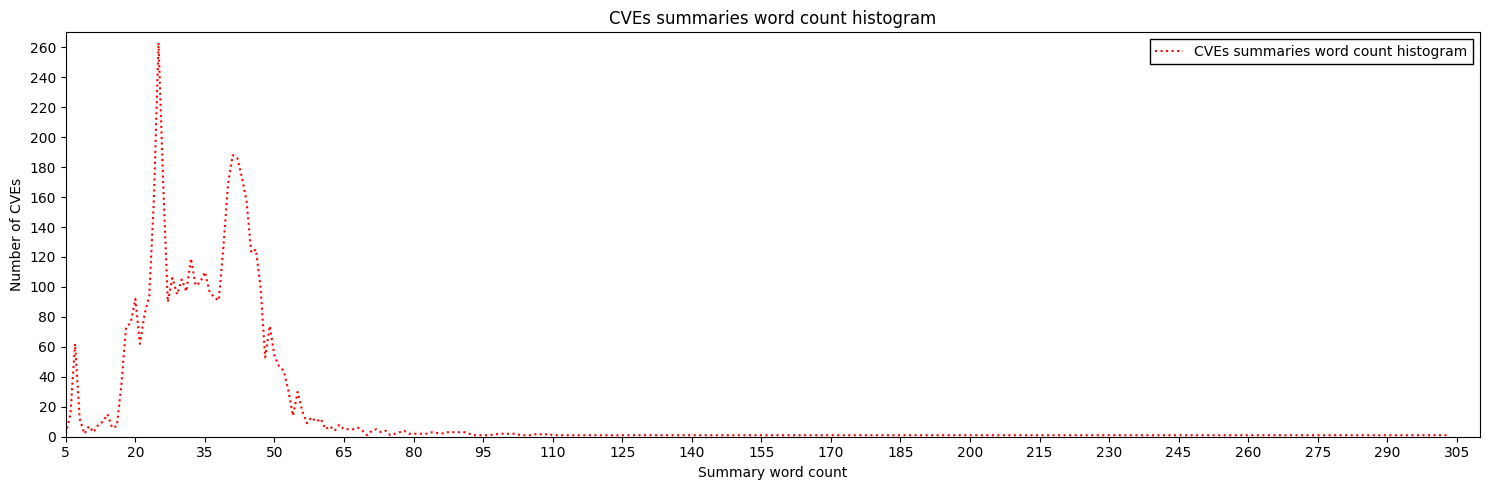

In [55]:
fig, ax = plt.subplots(figsize=(15, 5))

plt.plot(
    list(sizes),
    hist,
    label='CVEs summaries word count histogram',
    color='red',
    antialiased=True,
    linestyle='dotted'
)

plt.xlim((5, 310))
plt.ylim((0, 270))

plt.xticks(np.arange(5, 310, 15))
plt.yticks(np.arange(0, 270, 20))

plt.legend(
    ncols=1, loc='best', fancybox=False, framealpha=1,
    borderpad=0.4, edgecolor='black'
)

ax.set_xlabel('Summary word count')
ax.set_ylabel('Number of CVEs')

plt.title('CVEs summaries word count histogram')
plt.tight_layout()

plt.savefig('summaries_histogram.png', dpi=300)

In [11]:
y_true = pd.DataFrame([LABELS[l.strip()] for l in cves['labels'].to_list()])

In [12]:
m_w2v_10 = KNeighborsClassifier(n_neighbors=12)
m_w2v_50 = DecisionTreeClassifier(random_state=42)
m_w2v_100 = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
ms_w2v = [m_w2v_10, m_w2v_50, m_w2v_100]

In [13]:
SUBSAMPLE_SIZE = 1000
rng = np.random.default_rng()
random_subsample_idxs = rng.choice(len(y_true), size=SUBSAMPLE_SIZE, replace=False)
y_sub = [y_true[0].to_list()[i] for i in range(y_true.shape[0]) if i in random_subsample_idxs]
X_sub = [documents[i] for i in range(len(documents)) if i in random_subsample_idxs]

In [14]:
w2vs = [gensim_word2vec_lf_10, gensim_word2vec_lf_50, gensim_word2vec_lf_100]

for i in range(len(w2vs)):
    Xs = []
    
    for sentence in X_sub:
        wvs = []
    
        for word in sentence:
            try:
                wvs.append(w2vs[i].wv[word])
            except KeyError:
                wvs.append(np.zeros(VECTOR_SIZE))

        Xs.append(np.mean(wvs, axis=0))
    
    ms_w2v[i].fit(Xs, y_sub)

In [15]:
# Word2Vec
@labeling_function()
def lf_w2v_10(x):
    sentence = gensim.utils.simple_preprocess(x.summary)
    wvs = []
    
    for word in sentence:
        try:
            wvs.append(gensim_word2vec_lf_10.wv[word])
        except KeyError:
            wvs.append(np.zeros(VECTOR_SIZE))
            
    X = np.mean(wvs, axis=0)
    return m_w2v_10.predict([X])[0]

@labeling_function()
def lf_w2v_50(x):
    sentence = gensim.utils.simple_preprocess(x.summary)
    wvs = []
    
    for word in sentence:
        try:
            wvs.append(gensim_word2vec_lf_50.wv[word])
        except KeyError:
            wvs.append(np.zeros(VECTOR_SIZE))
            
    X = np.mean(wvs, axis=0)
    return m_w2v_50.predict([X])[0]
    
@labeling_function()
def lf_w2v_100(x):
    sentence = gensim.utils.simple_preprocess(x.summary)
    wvs = []
    
    for word in sentence:
        try:
            wvs.append(gensim_word2vec_lf_100.wv[word])
        except KeyError:
            wvs.append(np.zeros(VECTOR_SIZE))
            
    X = np.mean(wvs, axis=0)
    return m_w2v_100.predict([X])[0]


# Naive labeling functions
# Memory corruption labeling functions
@labeling_function()
def lf_has_memory(x):
    return LABELS['Memory corruption'] if 'memory' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_corruption(x):
    return LABELS['Memory corruption'] if 'corruption' in x.summary.lower() else ABSTAIN


# Gain privileges labeling functions
@labeling_function()
def lf_has_gain(x):
    return LABELS['Gain privileges'] if 'gain' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_privilege(x):
    return LABELS['Gain privileges'] if 'privilege' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_gain_privilege(x):
    return LABELS['Gain privileges'] if 'gain privilege' in x.summary.lower() else ABSTAIN


# Obtain Information labeling functions
@labeling_function()
def lf_has_obtain(x):
    return LABELS['Obtain Information'] if 'obtain' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_information(x):
    return LABELS['Obtain Information'] if 'information' in x.summary.lower() else ABSTAIN

# # None labeling functions
# @labeling_function()
# def lf_has_user(x):
#     return LABELS['None'] if 'user' in x.summary.lower() else ABSTAIN


# Sql Injection labeling functions
@labeling_function()
def lf_has_sql(x):
    return LABELS['Sql Injection'] if 'sql' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_injection(x):
    return LABELS['Sql Injection'] if 'injection' in x.summary.lower() else ABSTAIN


# CSRF labeling functions
@labeling_function()
def lf_has_csrf(x):
    return LABELS['CSRF'] if 'csrf' in x.summary.lower() else ABSTAIN


# Execute Code labeling functions
@labeling_function()
def lf_has_code(x):
    return LABELS['Execute Code'] if 'code' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_execution(x):
    return LABELS['Execute Code'] if 'execution' in x.summary.lower() else ABSTAIN


# Denial Of Service labeling functions
@labeling_function()
def lf_has_denial(x):
    return LABELS['Denial Of Service'] if 'denial' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_service(x):
    return LABELS['Denial Of Service'] if 'service' in x.summary.lower() else ABSTAIN


# Cross Site Scripting labeling functions
@labeling_function()
def lf_has_crosssite(x):
    return LABELS['Cross Site Scripting'] if 'cross-site' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_scripting(x):
    return LABELS['Cross Site Scripting'] if 'scripting' in x.summary.lower() else ABSTAIN


# Http response splitting labeling functions
@labeling_function()
def lf_has_html(x):
    return LABELS['Http response splitting'] if 'html' in x.summary.lower() else ABSTAIN


# Directory traversal labeling functions
@labeling_function()
def lf_has_traversal(x):
    return LABELS['Directory traversal'] if 'traversal' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_directory(x):
    return LABELS['Directory traversal'] if 'directory' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_files(x):
    return LABELS['Directory traversal'] if 'files' in x.summary.lower() else ABSTAIN


# Bypass a restriction or similar labeling functions
@labeling_function()
def lf_has_bypass(x):
    return LABELS['Bypass a restriction or similar'] if 'bypass' in x.summary.lower() else ABSTAIN


# Overflow labeling functions
@labeling_function()
def lf_has_overflow(x):
    return LABELS['Overflow'] if 'overflow' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_buffer(x):
    return LABELS['Overflow'] if 'buffer' in x.summary.lower() else ABSTAIN

@labeling_function()
def lf_has_heap(x):
    return LABELS['Overflow'] if 'heap' in x.summary.lower() else ABSTAIN

In [16]:
lfs = [
    lf_w2v_10,
    lf_w2v_50,
    lf_w2v_100,
    lf_has_memory,
    lf_has_corruption,
    lf_has_gain,
    lf_has_privilege,
    lf_has_gain_privilege,
    lf_has_obtain,
    lf_has_information,
    # lf_has_user,
    lf_has_sql,
    lf_has_injection,
    lf_has_csrf,
    lf_has_code,
    lf_has_execution,
    lf_has_denial,
    lf_has_service,
    lf_has_crosssite,
    lf_has_scripting,
    lf_has_html,
    lf_has_traversal,
    lf_has_directory,
    lf_has_files,
    lf_has_bypass,
    lf_has_overflow,
    lf_has_buffer,
    lf_has_heap,
]
len(lfs)

27

In [17]:
applier = PandasLFApplier(lfs=lfs)
L_train = applier.apply(df=cves)

100%|███| 5460/5460 [02:07<00:00, 42.92it/s]


In [19]:
# Porcentagem de pontos que cada LF positiva
# coverages = (L_train != ABSTAIN).mean(axis=0)
# lfs_coverages = {lfs[i].__repr__().split(' ')[1].replace(',', ''): coverages[i] for i in range(len(lfs))}

# for key, value in lfs_coverages.items():
#     print(f'{value * 100:06.3f}% -- {key}')

LFAnalysis(L=L_train, lfs=lfs).lf_summary()

,j,Polarity,Coverage,Overlaps,Conflicts
lf_w2v_10,0,"[1, 3, 4, 6, 7, 11, 12]",1.000000,1.000000,0.880403
lf_w2v_50,1,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]",1.000000,1.000000,0.880403
lf_w2v_100,2,"[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]",1.000000,1.000000,0.880403
lf_has_memory,3,[4],0.080952,0.080952,0.080952
lf_has_corruption,4,[4],0.065385,0.065385,0.065385
lf_has_gain,5,[1],0.046520,0.046520,0.046520
lf_has_privilege,6,[1],0.267399,0.267399,0.267399
lf_has_gain_privilege,7,[1],0.042308,0.042308,0.042308
lf_has_obtain,8,[3],0.313004,0.313004,0.221062
lf_has_information,9,[3],0.397802,0.397802,0.301648


In [16]:
# majority_model = MajorityLabelVoter()
# majority_acc = majority_model.score(L=L_train, Y=y_train, tie_break_policy='random')['accuracy']

In [20]:
label_model = LabelModel(cardinality=13, verbose=False)
label_model.fit(L_train=L_train, n_epochs=500, log_freq=100, seed=123)

probs = label_model.predict_proba(L=L_train)
y = probs_to_preds(probs, tie_break_policy='true-random')

acc, f1_macro = label_model.score(L=L_train, Y=y_true, metrics=['accuracy', 'f1_macro']).values()

100%|█| 500/500 [00:00<00:00, 698.07epoch/s]


In [21]:
print('---- Label model metrics')
print(f'Accuracy: {acc}')
print(f'F1 macro: {f1_macro}')
print('----')

---- Label model metrics
Accuracy: 0.5952380952380952
F1 macro: 0.4054657305912533
----


In [22]:
summaries = cves['summary'].to_numpy()

def preprocess(data):
    for i in range(len(data)):
        yield gensim.utils.simple_preprocess(data[i])

documents = list(preprocess(summaries))

gensim_word2vec = gensim.models.Word2Vec(
    documents,
    vector_size=VECTOR_SIZE,
    window=WINDOW_SIZE,
    min_count=MIN_COUNT,
    workers=WORKERS
)

gensim_word2vec.train(
    documents,
    total_examples=len(documents),
    epochs=10
)

sentences = [gensim.utils.simple_preprocess(sentence) for sentence in cves['summary'].to_numpy()]

X = []

for sentence in sentences:
    wvs = []
    
    for word in sentence:
        try:
            wvs.append(gensim_word2vec.wv[word])
        except KeyError:
            wvs.append(np.zeros(VECTOR_SIZE))
            
    X.append(np.mean(wvs, axis=0))

In [23]:
X_train, X_test, y_train, y_test, y_true_train, y_true_test = train_test_split(X, y, y_true, test_size=0.33, random_state=42)

In [24]:
def evaluate(labels, scores):
    print(f'\tAcc: {accuracy_score(labels, scores)}')
    print(f'\tPrecision macro: {precision_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tPrecision micro: {precision_score(labels, scores, average="micro", zero_division=0)}')
    print(f'\tRecall macro: {recall_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tRecall micro: {recall_score(labels, scores, average="micro", zero_division=0)}')
    print(f'\tF1 macro: {f1_score(labels, scores, average="macro", zero_division=0)}')
    print(f'\tF1 micro: {f1_score(labels, scores, average="micro", zero_division=0)}')

In [25]:
def train_with_random_forest():
    clf = RandomForestClassifier(n_estimators=300, max_depth=20, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f'\n----Random Forest metrics - with Snorkels preds')
    evaluate(y_test, y_pred)
    print('----')
    print(f'\n----Random Forest metrics - with true preds')
    evaluate(y_true_test, y_pred)
    print('----')

In [26]:
print('\n---- Snorkel Label Model metrics')
evaluate(y_true, y)
print('----')


---- Snorkel Label Model metrics
	Acc: 0.5952380952380952
	Precision macro: 0.4298564869985867
	Precision micro: 0.5952380952380952
	Recall macro: 0.4134150869302434
	Recall micro: 0.5952380952380952
	F1 macro: 0.4054657305912533
	F1 micro: 0.5952380952380952
----


In [27]:
train_with_random_forest()


----Random Forest metrics - with Snorkels preds
	Acc: 0.7974472807991121
	Precision macro: 0.7532972280809092
	Precision micro: 0.7974472807991121
	Recall macro: 0.5913576811553743
	Recall micro: 0.7974472807991121
	F1 macro: 0.6285162320931729
	F1 micro: 0.7974472807991121
----

----Random Forest metrics - with true preds
	Acc: 0.5887902330743618
	Precision macro: 0.5061281974033571
	Precision micro: 0.5887902330743618
	Recall macro: 0.3737527972362116
	Recall micro: 0.5887902330743618
	F1 macro: 0.38449107792415843
	F1 micro: 0.5887902330743618
----
